In [50]:
import os
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras import datasets, layers, models, metrics
import matplotlib.pyplot as plt

# import modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# sklearn utilities
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# sklearn models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder

In [51]:
from PIL import Image

#run this if images are not saved locally as np array

#in order for this to work, you need to download the data from kaggle as a zip and upload it to the following directory:
# /content/drive/MyDrive/CS3540/CS3540-Assignments/final-project/data/

glioma_path = 'data/Brain_Cancer raw MRI data/Brain_Cancer/brain_glioma'
menin_path = 'data/Brain_Cancer raw MRI data/Brain_Cancer/brain_menin'
tumor_path = 'data/Brain_Cancer raw MRI data/Brain_Cancer/brain_tumor'

image_data = []
image_labels = []

target_size = (224, 224) # this is a hyper param, rescaled size of images that will be used as the input shape for the CNN



for directory_path in [glioma_path, menin_path, tumor_path]:
    if os.path.exists(directory_path):
        label = os.path.basename(directory_path) # directory corresponds to label
        for filename in os.listdir(directory_path):
            full_path = os.path.join(directory_path, filename)
            if os.path.isfile(full_path):
                try:
                    img = Image.open(full_path).convert('RGB')
                    img_resized = img.resize(target_size) # <- we resize so the image data isn't incredibly huge but still provides enough information to train on
                    img_array = np.asarray(img_resized)
                    image_data.append(img_array)
                    image_labels.append(label)
                except Exception as e:
                    print(f"Error processing {full_path}: {e}")
    else:
        print(f"Directory not found: {directory_path}")

# Convert the lists to numpy arrays
image_data = np.array(image_data)
image_labels = np.array(image_labels)

print("Image data shape:", image_data.shape)
print("Image labels shape:", image_labels.shape)
print("Example labels:", image_labels[:10])

Image data shape: (6056, 224, 224, 3)
Image labels shape: (6056,)
Example labels: ['brain_glioma' 'brain_glioma' 'brain_glioma' 'brain_glioma'
 'brain_glioma' 'brain_glioma' 'brain_glioma' 'brain_glioma'
 'brain_glioma' 'brain_glioma']


In [52]:
# Save the image data and labels
# only run this cell if generating images for the first time after running the above cell
np.save('data/image_data_224.npy', image_data)
np.save('data/image_labels_224.npy', image_labels)

print("Image data and labels saved as 'image_data_224.npy' and 'image_labels_224.npy'")

Image data and labels saved as 'image_data_224.npy' and 'image_labels_224.npy'


In [53]:
# load image data, if saved locally

image_data = np.load('data/image_data_224.npy')
image_labels = np.load('data/image_labels_224.npy')

In [54]:
# Normalize the image data

# run this cell after images have either been loaded or generated in the above cell
for image in image_data:
  image = image / 255

print("Image data normalized.")

Image data normalized.


In [55]:
class_names = ['glioma', 'menin', 'tumor']

x_train, x_test, y_train, y_test = train_test_split(image_data, image_labels, test_size=0.2, random_state=42)

print("Data split into training and testing sets.")
print("X_train shape:", x_train.shape)
print("X_test shape:", x_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

Data split into training and testing sets.
X_train shape: (4844, 224, 224, 3)
X_test shape: (1212, 224, 224, 3)
y_train shape: (4844,)
y_test shape: (1212,)


In [56]:
#run this cell to change image labels to ints (CNN wants this and won't work without it)

# change labels from strings to int

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the string labels to integer labels
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)


# Update y_train and y_test to use the encoded labels
y_train = y_train_encoded
y_test = y_test_encoded

In [57]:
base_model = tf.keras.applications.MobileNetV2(input_shape = (224, 224, 3), include_top = False, weights = 'imagenet')
base_model.trainable = False
base_model.summary()

Model: "mobilenetv2_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_6[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

In [58]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(len(class_names), activation = 'softmax')
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.3),
])
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [61]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.4)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)


In [62]:
base_learning_rate = 0.000075
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [63]:
initial_epochs = 150

loss0, accuracy0 = model.evaluate(x_test, y_test)

38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 78ms/step - accuracy: 0.3226 - loss: 1.3168


Epoch 1/150
152/152 ━━━━━━━━━━━━━━━━━━━━ 17s 98ms/step - accuracy: 0.4176 - loss: 1.2527 - val_accuracy: 0.6056 - val_loss: 0.8671
Epoch 2/150
152/152 ━━━━━━━━━━━━━━━━━━━━ 14s 93ms/step - accuracy: 0.5621 - loss: 0.9683 - val_accuracy: 0.7005 - val_loss: 0.7033
Epoch 3/150
152/152 ━━━━━━━━━━━━━━━━━━━━ 14s 93ms/step - accuracy: 0.6369 - loss: 0.8077 - val_accuracy: 0.7566 - val_loss: 0.6084
Epoch 4/150
152/152 ━━━━━━━━━━━━━━━━━━━━ 14s 93ms/step - accuracy: 0.6926 - loss: 0.7205 - val_accuracy: 0.7797 - val_loss: 0.5465
Epoch 5/150
152/152 ━━━━━━━━━━━━━━━━━━━━ 14s 93ms/step - accuracy: 0.7223 - loss: 0.6520 - val_accuracy: 0.8028 - val_loss: 0.5021
Epoch 6/150
152/152 ━━━━━━━━━━━━━━━━━━━━ 14s 92ms/step - accuracy: 0.7459 - loss: 0.5963 - val_accuracy: 0.8210 - val_loss: 0.4696
Epoch 7/150
152/152 ━━━━━━━━━━━━━━━━━━━━ 14s 92ms/step - accuracy: 0.7719 - loss: 0.5588 - val_accuracy: 0.8416 - val_loss: 0.4416
Epoch 8/150
152/152 ━━━━━━━━━━━━━━━━━━━━ 14s 92ms/step - accuracy: 0.7742 - loss: 0

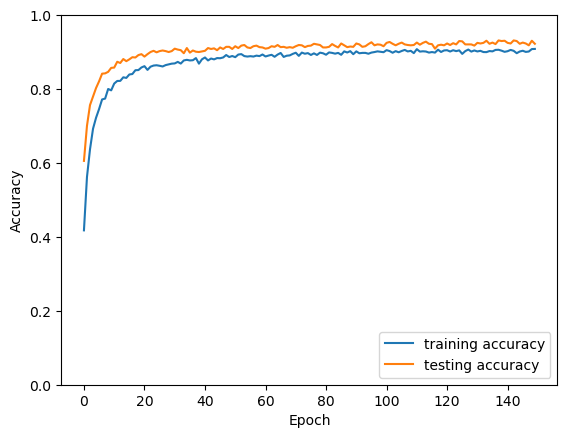

In [64]:
history = model.fit(x_train, y_train, epochs=initial_epochs,
                    validation_data=(x_test, y_test))


plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label = 'testing accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.0, 1])
plt.legend(loc='lower right')

checkpoint_path = "transfer_learning_checkpoints.weights.h5"
model.save_weights(checkpoint_path)

test_loss, test_acc = model.evaluate(x_test,  y_test, verbose=2)


print("accuracy on test dataset: ", test_acc)